In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tidegravity

In [39]:
dados = pd.read_csv("dados.txt", parse_dates=[1], index_col=1)
dados

,estacao,leitura1,leitura2,leitura3,altitude,longitude,latitude
data,,,,,,,
2024-08-20 10:13:00-03:00,pilar,2232.010,2231.985,2231.996,726.78,-46.7353,-23.5594
2024-08-20 10:46:00-03:00,elevador,2232.149,2232.145,2232.160,726.78,-46.7351,-23.5589
2024-08-20 11:03:00-03:00,andar1,2231.042,2231.039,2231.050,730.74,-46.7351,-23.5589
2024-08-20 11:14:00-03:00,andar2,2229.900,2229.880,2229.890,734.79,-46.7351,-23.5589
2024-08-20 11:32:00-03:00,andar3,2228.741,2228.738,2228.735,738.76,-46.7351,-23.5589
2024-08-20 11:47:00-03:00,pilar,2231.933,2231.935,2231.929,726.78,-46.7353,-23.5594


In [51]:
conversao = pd.read_csv("G965.csv", comment="/", skipinitialspace=True) 
conversao

,Instrument,Milligal
0,0.00,1.00909
100,100.91,1.00906
200,201.81,1.00906
300,302.72,1.00908
400,403.63,1.00912
...,...,...
6600,6673.05,1.00937
6700,6773.99,1.00907
6800,6874.89,1.00871
6900,6975.76,1.00829


In [52]:
indice = (dados.leitura1 - dados.leitura1 % 100).astype(int)
indice

data
2024-08-20 10:13:00-03:00    2200
2024-08-20 10:46:00-03:00    2200
2024-08-20 11:03:00-03:00    2200
2024-08-20 11:14:00-03:00    2200
2024-08-20 11:32:00-03:00    2200
2024-08-20 11:47:00-03:00    2200
Name: leitura1, dtype: int64

In [53]:
conv = conversao.loc[indice]
conv

,Instrument,Milligal
2200,2221.4,1.0108
2200,2221.4,1.0108
2200,2221.4,1.0108
2200,2221.4,1.0108
2200,2221.4,1.0108
2200,2221.4,1.0108


In [71]:
g_pilar = 978641.83

In [57]:
mgal = (dados.leitura1 - conv.index) * conv.Milligal.values + conv.Instrument.values
mgal

data
2024-08-20 10:13:00-03:00    2253.755708
2024-08-20 10:46:00-03:00    2253.896209
2024-08-20 11:03:00-03:00    2252.777254
2024-08-20 11:14:00-03:00    2251.622920
2024-08-20 11:32:00-03:00    2250.451403
2024-08-20 11:47:00-03:00    2253.677876
dtype: float64

In [58]:
_, _, tide = tidegravity.solve_longman_tide(dados.latitude, dados.longitude, dados.altitude, dados.index.tz_convert(None))

In [59]:
a = mgal - tide
a

data
2024-08-20 10:13:00-03:00    2253.731319
2024-08-20 10:46:00-03:00    2253.843182
2024-08-20 11:03:00-03:00    2252.711059
2024-08-20 11:14:00-03:00    2251.548967
2024-08-20 11:32:00-03:00    2250.366257
2024-08-20 11:47:00-03:00    2253.584995
dtype: float64

In [60]:
d = a - a.iloc[0]
d

data
2024-08-20 10:13:00-03:00    0.000000
2024-08-20 10:46:00-03:00    0.111863
2024-08-20 11:03:00-03:00   -1.020260
2024-08-20 11:14:00-03:00   -2.182352
2024-08-20 11:32:00-03:00   -3.365062
2024-08-20 11:47:00-03:00   -0.146324
dtype: float64

In [66]:
dt = (d.index - d.index[0]).to_series().dt.total_seconds()
dt

data
0 days 00:00:00       0.0
0 days 00:33:00    1980.0
0 days 00:50:00    3000.0
0 days 01:01:00    3660.0
0 days 01:19:00    4740.0
0 days 01:34:00    5640.0
Name: data, dtype: float64

In [67]:
drift = (d.iloc[-1]) / dt.iloc[-1]
drift

-2.5944024679629625e-05

In [69]:
b = d - drift * dt.values
b

data
2024-08-20 10:13:00-03:00    0.000000
2024-08-20 10:46:00-03:00    0.163232
2024-08-20 11:03:00-03:00   -0.942428
2024-08-20 11:14:00-03:00   -2.087397
2024-08-20 11:32:00-03:00   -3.242088
2024-08-20 11:47:00-03:00    0.000000
dtype: float64

In [72]:
g = g_pilar + b
g

data
2024-08-20 10:13:00-03:00    978641.830000
2024-08-20 10:46:00-03:00    978641.993232
2024-08-20 11:03:00-03:00    978640.887572
2024-08-20 11:14:00-03:00    978639.742603
2024-08-20 11:32:00-03:00    978638.587912
2024-08-20 11:47:00-03:00    978641.830000
dtype: float64

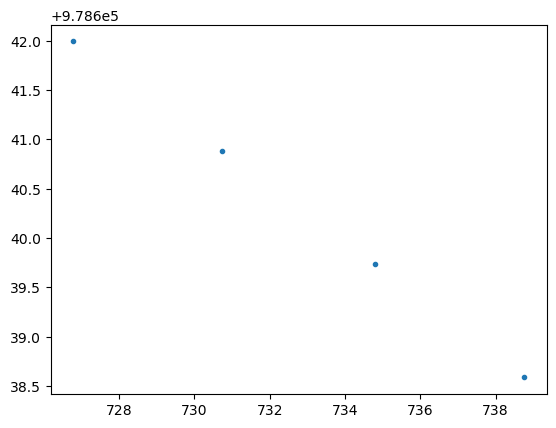

In [75]:
plt.plot(dados.altitude.iloc[1:-1], g.iloc[1:-1], ".")